# PART I: Theory Questions

In [5]:
%%html
<img src='IMG_20210319_180112_N.jpg',width=1920 height=1080>

In [2]:
%%html
<img src='IMG_20210319_180213_N.jpg',width=1920 height=1080>

In [3]:
%%html
<img src='IMG_20210319_180244_N.jpg',width=1920 height=1080>

# PART II: Classification of Images

### Libraries

In [16]:
#!pip install opencv-python
from collections import Counter
import numpy as np
import filters
import os
import datetime
import cv2
from math import sqrt

from tqdm import tqdm # to measure processing times

# KNN CLASS

In [2]:
class KNN:
    # initial value 
    def __init__(self, k=3, k_fold=3, method='NoMethod', dist='euclidean', weighted=False, photo_size=(32, 32)):
        self.k = k
        self.k_fold = k_fold
        self.method = method

        if dist == 'euclidean':
            self.dist = self.euclidean_distance
        elif dist == 'manhattan':
            self.dist = self.manhattan_distance
        else:
            raise Exception

        self.weighted = weighted
        self.photo_size = photo_size
        self.user_based_table = None
    
    # function created to save the properties of the object to the file
    def __str__(self):
        copy_method = self.method
        
        unified = str(self.k) + ' ' + str(self.k_fold) + ' ' + copy_method + ' ' + str(self.dist) + ' ' + str(
            self.weighted) + ' ' + str(self.photo_size)
        return unified
    # save numpy array
    def save_knn(self, filename='knn_weight.npy'):
        with open(filename, 'wb') as f:
            np.save(f, np.array(self.user_based_table))
    # load -> saved numpy array
    def load_knn(self, filename='knn_weight.npy'):
        with open(filename, 'rb') as f:
            self.user_based_table = np.load(f, allow_pickle=True)

    # calculate euclidean distance
    def euclidean_distance(self, a, b):
        result = np.float64(0)
        for i in range(len(a)):
            result += np.power((a[i] - b[i]), 2, dtype=np.float64)
        return sqrt(result)

    # calculate manhattan distance
    def manhattan_distance(self, a, b):
        result = np.float64(0)
        for i in range(len(a)):
            result += abs(a[i] - b[i])
        return result

    def user_based_table_creator(self):
        # checking directory
        if not os.path.exists('train') or not os.path.isdir('train'):
            raise Exception("train directory not found")
        # get directories in train directory
        list_of_subdirectory = os.listdir('train')
        dict_list_of_subdirectory = {}
        # save image data
        data = []
        
        for i in range(len(list_of_subdirectory)):
            # if file is directory
            if os.path.isdir('train/' + list_of_subdirectory[i]):
                
                dict_list_of_subdirectory[i] = list_of_subdirectory[i]
                # get images from directory
                list_of_image = os.listdir('train/' + list_of_subdirectory[i])

                for j in list_of_image:
                    # read image from disk
                    img = cv2.imread('train/' + list_of_subdirectory[i] + '/' + j).astype(np.uint8)
                    # resize image
                    resized_img = cv2.resize(img, self.photo_size)
                    # converting image
                    out = None
                    if self.method == 'NoMethod':
                        out = resized_img
                    elif self.method == 'Gabor':
                        out = filters.Gabor_process(resized_img)
                    elif self.method == 'Canny':
                        out = filters.Canny_edge(resized_img)
                    # image to 1D array
                    image_to_array = out.flatten()
                    # add image to data list
                    data.append([i, image_to_array])
        # save data to object variable
        self.user_based_table = np.array(data, dtype=object)
        
    # calculate 2 matrix distance
    def calc_distance(self, train_data, test_data):
        # fills similarity matrix
        result = []
        for i in range(len(test_data)):
            test_list = []
            for j in range(len(train_data)):
                # self.dist = functional reference
                calc = self.dist(test_data[i][1], train_data[j][1])
                # save result
                test_list.append(calc)
            result.append(test_list)
        return result

    def calc_acc(self, sim_matrix, sorted_sim_matrix, train_data, test_data):

        true_val = 0
        false_val = 0
        # weighted knn
        if self.weighted:
            for i in range(len(sorted_sim_matrix)):
                # empty neightbour list
                neighbour = {}
                # get k nearest neighbour from list
                get_knn_list = sorted_sim_matrix[i][:self.k]
                # add neighbour type in list -> covid = 0 , normal = 1 , viral = 2
                for knn_value in get_knn_list:
                    # distance to weight
                    weight = np.divide(1, sim_matrix[i][knn_value], dtype=np.float64)
                    # save variable to dictionary
                    if train_data[knn_value][0] in neighbour:
                        neighbour[train_data[knn_value][0]] += weight
                    else:
                        neighbour[train_data[knn_value][0]] = weight
                # get max value
                keymax = max(neighbour, key=neighbour.get)
                # if prediction true increase true value
                if keymax == test_data[i][0]:
                    true_val += 1
                # else increase false value
                else:
                    false_val += 1
        # normal knn
        else:
            for i in range(len(sorted_sim_matrix)):
                # empty neighbour# accuracy process start list
                neighbour = []
                # get k nearest neighbour from list
                get_knn_list = sorted_sim_matrix[i][:self.k]
                # add neighbour type in list -> covid = 0 , normal = 1 , viral = 2
                for knn_value in get_knn_list:
                    neighbour.append(train_data[knn_value][0])
                # count types list
                count_neighbour = Counter(neighbour)
                # get most max value from neighbour list
                max_value = count_neighbour.most_common(1)
                # if prediction true increase true value
                if max_value[0][0] == test_data[i][0]:
                    true_val += 1
                # else increase false value
                else:
                    false_val += 1
        # return calculated accuracy
        return 100 * (true_val / (true_val + false_val))

    def knn_process(self, file_path, output):
        if self.user_based_table is None:
            raise Exception('No training')

        current_time = datetime.date.today().strftime("%d/%m/%Y") + '_' + datetime.datetime.now().strftime("%H:%M:%S")
        current_time = current_time.replace(':', '_')
        current_time = current_time.replace('/', '_')

        acc_file = open(file_path.split('.')[0] + '_' + current_time + '.txt', 'w')
        acc_file.write(self.__str__())
        acc_file.flush()
        accuracy_list = []
        # K-Fold Cross validation
        piece = len(self.user_based_table) // self.k_fold  # lenght of the every test piece
        for i in range(1, self.k_fold + 1):
            # split test data
            test_data = self.user_based_table[(i - 1) * piece:i * piece]
            # previously used test data
            piece_before_test_data = self.user_based_table[:(i - 1) * piece]
            # data -> after test piece
            piece_after_test_data = self.user_based_table[i * piece:]
            # combine piece_before_test_data and piece_after_test_data -> train data
            train_data = np.concatenate((piece_before_test_data, piece_after_test_data))
            # distance matrix
            sim_matrix = self.calc_distance(train_data, test_data)
            # output sorted array indices
            sorted_sim_matrix = np.argsort(sim_matrix, axis=1)
            # accuracy process start
            accuracy = self.calc_acc(sim_matrix, sorted_sim_matrix, train_data, test_data)
            accuracy_list.append(accuracy)
            print('Kfold =', i, '-> Accuracy:', accuracy, file=output)

        print('\n' + str(accuracy_list), file=acc_file)
        print('\nAverage of the accuracies:', sum(accuracy_list)/len(accuracy_list))
        acc_file.close()


## Generate processed image array

In [3]:
def generate_user_based_tables():
    if not os.path.exists('user_based_table'):
        os.makedirs('user_based_table')

    method_list = ["NoMethod", "Gabor", "Canny"]
    photo_size_list = [(4, 4), (8, 8), (16, 16), (28, 28), (32, 32), (64, 64)]
    for i in method_list:
        for j in photo_size_list:
            # Timer starts
            a = datetime.datetime.now()

            Knn_object = KNN(k=3, k_fold=5, method=i, dist='euclidean', weighted=True, photo_size=j)

            Knn_object.user_based_table_creator()
            # Timer ends
            b = datetime.datetime.now()
            print("User Based Table " + i + str(j) + '.npy ' + "Created and Saved", b - a, " ms", (b - a).seconds,
                  " second")

            Knn_object.save_knn('user_based_table/' + i + str(j) + '.npy')

# generate_user_based_tables()

# Generated numpy image model time

User Based Table NoMethod(4, 4).npy Created and Saved 0:00:28.341771  ms 28  second

User Based Table NoMethod(8, 8).npy Created and Saved 0:00:28.493598  ms 28  second

User Based Table NoMethod(16, 16).npy Created and Saved 0:00:28.002782  ms 28  second

User Based Table NoMethod(28, 28).npy Created and Saved 0:00:27.275152  ms 27  second

User Based Table NoMethod(32, 32).npy Created and Saved 0:00:27.567387  ms 27  second

User Based Table NoMethod(64, 64).npy Created and Saved 0:00:27.611409  ms 27  second

User Based Table Gabor(4, 4).npy Created and Saved 0:00:44.820520  ms 44  second

User Based Table Gabor(8, 8).npy Created and Saved 0:00:51.660070  ms 51  second

User Based Table Gabor(16, 16).npy Created and Saved 0:01:19.077418  ms 79  second

User Based Table Gabor(28, 28).npy Created and Saved 0:02:33.763469  ms 153  second

User Based Table Gabor(32, 32).npy Created and Saved 0:03:07.699713  ms 187  second

User Based Table Gabor(64, 64).npy Created and Saved 0:10:18.144965  ms 618  second

User Based Table Canny(4, 4).npy Created and Saved 0:00:27.719058  ms 27  second

User Based Table Canny(8, 8).npy Created and Saved 0:00:27.801271  ms 27  second

User Based Table Canny(16, 16).npy Created and Saved 0:00:28.968399  ms 28  second

User Based Table Canny(28, 28).npy Created and Saved 0:00:29.443226  ms 29  second

User Based Table Canny(32, 32).npy Created and Saved 0:00:29.213588  ms 29  second

User Based Table Canny(64, 64).npy Created and Saved 0:00:29.488017  ms 29  second

## Calculate all model optimum k and kfold value 

In [4]:
def knn_process_given_file(file_path, output):
    # change k value
    for k_value in tqdm(range(3, 11, 2)):
        # change k fold value
        for k_fold_value in range(3, 11):
            # weighted knn or normal knn
            for on_off in tqdm([False, True]):
                print("filename=", file_path, "k_value=", k_value, "k_fold_value=", k_fold_value, "weight on/off=", on_off, file=output)
                knn_object = KNN(k=k_value, k_fold=k_fold_value, dist='euclidean', weighted=on_off)
                knn_object.load_knn(file_path)
                # Timer starts
                a = datetime.datetime.now()
                # KNN process start
                knn_object.knn_process(file_path, output)
                # Timer ends
                b = datetime.datetime.now()
                print("Running time", b - a, " ms", (b - a).seconds, "second", file=output)
                output.flush()


if not os.path.exists("user_based_table") or not os.path.isdir("user_based_table"):
    raise Exception("train directory not found")
else:
    # get models
    processsed_files = os.listdir("user_based_table")
    # select file and send process
    for i in processsed_files:
        output = open('output_'+i+'.txt', 'w')
        knn_process_given_file('user_based_table/'+i, output)

  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-2-0f63ae2656e2>:37: RuntimeWarning: overflow encountered in ubyte_scalars
  result += np.power((a[i] - b[i]), 2, dtype=np.float64)

 50%|█████     | 1/2 [1:47:14<1:47:14, 6434.31s/it]<ipython-input-2-0f63ae2656e2>:106: RuntimeWarning: divide by zero encountered in true_divide
  weight = np.divide(1, sim_matrix[i][knn_value], dtype=np.float64)

100%|██████████| 4/4 [14:22:54<00:00, 12943.73s/it]  


# Error Analysis

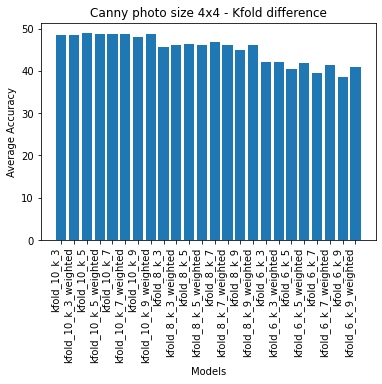

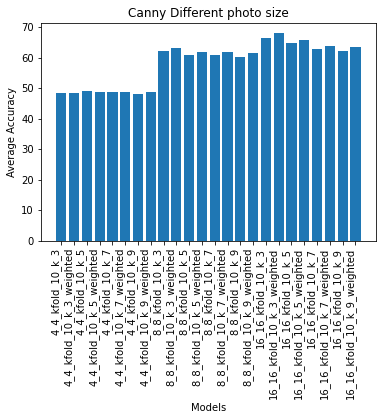

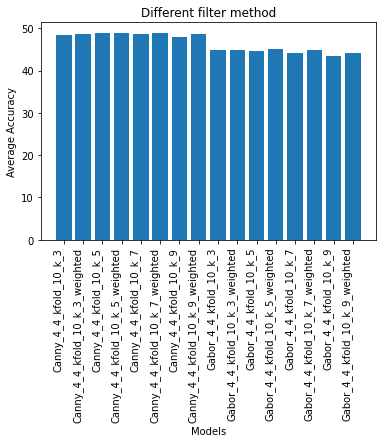

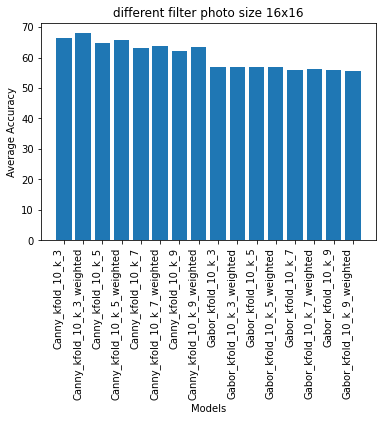

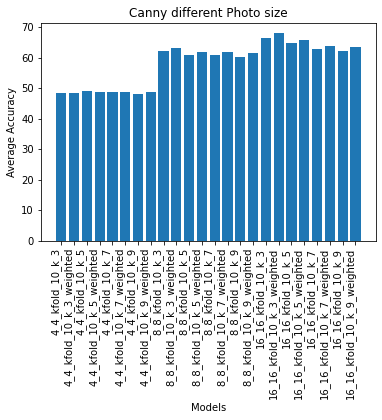

In [54]:
# I transferred my results to report!

# method - size - size - kfold - kfold number - k value - k number 

# Running time 0:06:04.515709  ms 364 second
Canny_4_4_kfold_10_k_3 = [51.29032258064517,49.67741935483871,49.03225806451613,52.903225806451616,54.83870967741935,48.064516129032256,53.5483870967742,36.774193548387096,42.58064516129032,45.483870967741936]
# Running time 0:06:02.299062  ms 362 second
Canny_4_4_kfold_10_k_3_weighted = [53.2258064516129,52.25806451612903,50.32258064516129,52.903225806451616,53.2258064516129,47.41935483870968,50.645161290322584,37.74193548387097,44.193548387096776,43.54838709677419]
# Running time 0:06:08.455728  ms 368 second
Canny_4_4_kfold_10_k_5 = [45.483870967741936,45.483870967741936,46.45161290322581,56.12903225806451,58.06451612903226,53.5483870967742,55.483870967741936,38.064516129032256,42.90322580645161,48.064516129032256]
# Running time 0:06:05.239329  ms 365 second
Canny_4_4_kfold_10_k_5_weighted = [52.903225806451616,50.32258064516129,47.74193548387097,54.83870967741935,56.774193548387096,50.967741935483865,51.61290322580645,37.096774193548384,41.29032258064516,44.193548387096776]
# Running time 0:06:06.005577  ms 366 second
Canny_4_4_kfold_10_k_7 = [45.483870967741936,41.29032258064516,44.193548387096776,56.12903225806451,60.322580645161295,53.2258064516129,54.516129032258064,36.774193548387096,48.064516129032256,46.45161290322581]
# Running time 0:06:04.452621  ms 364 second
Canny_4_4_kfold_10_k_7_weighted = [53.87096774193548,47.41935483870968,46.774193548387096,54.19354838709678,58.70967741935483,50.645161290322584,50.967741935483865,35.483870967741936,44.516129032258064,45.16129032258064]
# Running time 0:06:05.439969  ms 365 second
Canny_4_4_kfold_10_k_9 = [46.12903225806452,42.25806451612903,42.58064516129032,57.74193548387097,58.06451612903226,55.16129032258065,54.19354838709678,36.45161290322581,44.83870967741935,42.58064516129032]
# Running time 0:06:06.170802  ms 366 second
Canny_4_4_kfold_10_k_9_weighted = [54.19354838709678,46.12903225806452,46.12903225806452,55.483870967741936,58.06451612903226,51.29032258064517,51.29032258064517,36.12903225806451,43.54838709677419,43.87096774193549]


# Running time 0:05:57.465326  ms 357 second
Canny_4_4_kfold_8_k_3 = [52.57731958762887,45.618556701030926,45.876288659793815,48.96907216494845,46.90721649484536,48.45360824742268,37.11340206185567,38.91752577319588]
# Running time 0:05:57.126346  ms 357 second
Canny_4_4_kfold_8_k_3_weighted = [53.350515463917525,50.51546391752577,45.36082474226804,49.22680412371135,47.42268041237113,45.618556701030926,37.88659793814433,38.91752577319588]
# Running time 0:05:57.308577  ms 357 second
Canny_4_4_kfold_8_k_5 = [44.84536082474227,44.329896907216494,49.48453608247423,53.608247422680414,50.77319587628865,48.45360824742268,37.371134020618555,41.75257731958763]
# Running time 0:05:57.697473  ms 357 second
Canny_4_4_kfold_8_k_5_weighted = [51.546391752577314,50.25773195876289,46.649484536082475,51.28865979381443,49.48453608247423,44.58762886597938,35.56701030927835,38.91752577319588]
# Running time 0:06:03.111719  ms 363 second
Canny_4_4_kfold_8_k_7 = [44.58762886597938,43.55670103092783,50.25773195876289,56.44329896907217,51.80412371134021,49.22680412371135,38.144329896907216,40.72164948453608]
# Running time 0:05:59.455696  ms 359 second
Canny_4_4_kfold_8_k_7_weighted = [52.31958762886598,49.74226804123711,46.649484536082475,52.57731958762887,50.77319587628865,45.103092783505154,36.08247422680412,36.597938144329895]
# Running time 0:05:57.622847  ms 357 second
Canny_4_4_kfold_8_k_9 = [42.2680412371134,42.52577319587629,48.71134020618557,55.670103092783506,51.28865979381443,46.649484536082475,36.08247422680412,37.11340206185567]
# Running time 0:06:00.235409  ms 360 second
Canny_4_4_kfold_8_k_9_weighted = [51.546391752577314,49.22680412371135,46.90721649484536,52.83505154639175,51.03092783505154,44.58762886597938,35.30927835051546,36.855670103092784]


# Running time 0:05:45.616434  ms 345 second
Canny_4_4_kfold_6_k_3 = [39.575289575289574,49.034749034749034,45.75289575289575,47.49034749034749,34.36293436293436,36.1003861003861]
# Running time 0:05:37.150093  ms 337 second
Canny_4_4_kfold_6_k_3_weighted = [42.471042471042466,49.80694980694981,43.62934362934363,46.33204633204633,34.942084942084946,34.74903474903475]
# Running time 0:05:44.520731  ms 344 second
Canny_4_4_kfold_6_k_5 = [35.907335907335906,42.471042471042466,45.75289575289575,48.84169884169884,34.74903474903475,34.55598455598455]
# Running time 0:05:38.382575  ms 338 second
Canny_4_4_kfold_6_k_5_weighted = [42.084942084942085, 46.91119691119691, 47.49034749034749, 46.71814671814672, 33.78378378378378, 34.55598455598455]
# Running time 0:05:37.697984  ms 337 second
Canny_4_4_kfold_6_k_7 = [ 33.204633204633204, 44.5945945945946, 45.559845559845556, 48.06949806949807, 33.97683397683397, 31.27413127413127]
# Running time 0:05:38.054335  ms 338 second
Canny_4_4_kfold_6_k_7_weighted = [40.54054054054054, 47.68339768339768, 47.87644787644788, 46.71814671814672, 32.818532818532816, 32.625482625482626]
# Running time 0:05:37.794604  ms 337 second
Canny_4_4_kfold_6_k_9 = [32.625482625482626, 42.664092664092664, 45.366795366795365, 48.64864864864865, 32.432432432432435, 29.343629343629345]
# Running time 0:05:37.472204  ms 337 second
Canny_4_4_kfold_6_k_9_weighted = [40.34749034749035, 47.68339768339768, 47.87644787644788, 47.10424710424711, 31.467181467181465, 31.467181467181465]


# Running time 0:23:45.418119  ms 1425 second
Canny_8_8_kfold_10_k_3 = [61.29032258064516,70.3225806451613,69.03225806451613,81.61290322580645,80.0,79.03225806451613,68.70967741935485,31.93548387096774,40.0,40.32258064516129]
# Running time 0:24:12.614905  ms 1452 second
Canny_8_8_kfold_10_k_3_weighted = [65.16129032258064,75.80645161290323,70.3225806451613,81.93548387096774,80.0,79.03225806451613,68.38709677419355,31.61290322580645,39.67741935483871,40.0]
# Running time 0:24:16.557208  ms 1456 second
Canny_8_8_kfold_10_k_5 = [56.774193548387096,63.87096774193548,68.70967741935485,82.58064516129032,78.38709677419354,81.61290322580645,70.96774193548387,29.677419354838708,37.41935483870968,38.064516129032256]
# Running time 0:24:05.853888  ms 1445 second
Canny_8_8_kfold_10_k_5_weighted = [60.64516129032258,71.61290322580646,70.0,83.22580645161291,78.70967741935485,81.29032258064515,70.0,29.03225806451613,37.74193548387097,36.45161290322581]

# Running time 0:24:19.726139  ms 1459 second
Canny_8_8_kfold_10_k_7 = [56.12903225806451,60.967741935483865,67.0967741935484,82.25806451612904,81.61290322580645,83.54838709677419,72.90322580645162,28.70967741935484,36.12903225806451,38.064516129032256]
# Running time 0:24:23.601159  ms 1463 second
Canny_8_8_kfold_10_k_7_weighted = [60.64516129032258,68.06451612903226,69.03225806451613,82.9032258064516,81.93548387096774,84.19354838709677,71.61290322580646,27.419354838709676,35.80645161290323,36.45161290322581]
# Running time 0:24:24.509024  ms 1464 second
Canny_8_8_kfold_10_k_9 = [54.83870967741935,57.74193548387097,70.3225806451613,84.19354838709677,83.54838709677419,86.45161290322581,72.25806451612902,25.483870967741932,33.5483870967742,34.516129032258064]
# Running time 0:23:13.857003  ms 1393 second
Canny_8_8_kfold_10_k_9_weighted = [60.64516129032258,65.16129032258064,71.61290322580646,84.51612903225806,83.87096774193549,87.09677419354838,70.64516129032258,24.838709677419356,34.193548387096776,33.225806451612904]

# Running time 1:47:14.299264  ms 6434 second
Canny_16_16_kfold_10_k_3 = [54.83870967741935,61.61290322580645,60.322580645161295,92.25806451612904,95.80645161290322,96.12903225806451,71.61290322580646,36.774193548387096,44.516129032258064,50.0]
# Running time 1:46:41.874705  ms 6401 second
Canny_16_16_kfold_10_k_3_weighted = [60.967741935483865,68.70967741935485,62.58064516129033,92.25806451612904,95.80645161290322,96.12903225806451,71.61290322580646,36.774193548387096,44.516129032258064,50.0]
# Running time 1:46:32.171966  ms 6392 second
Canny_16_16_kfold_10_k_5 = [50.32258064516129,60.967741935483865,56.774193548387096,92.90322580645162,97.41935483870968,96.12903225806451,71.61290322580646,35.483870967741936,41.612903225806456,43.87096774193549]
# Running time 1:46:30.776713  ms 6390 second
Canny_16_16_kfold_10_k_5_weighted = [55.16129032258065,64.83870967741936,58.387096774193544,93.2258064516129,97.41935483870968,96.12903225806451,71.61290322580646,35.483870967741936,41.612903225806456,42.58064516129032]
# Running time 1:48:38.208333  ms 6518 second
Canny_16_16_kfold_10_k_7 = [48.70967741935484,54.516129032258064,54.19354838709678,93.54838709677419,98.06451612903226,97.09677419354838,72.90322580645162,30.32258064516129,40.0,40.64516129032258]
# Running time 1:50:41.212184  ms 6641 second
Canny_16_16_kfold_10_k_7_weighted = [50.967741935483865,61.29032258064516,55.16129032258065,93.87096774193549,98.06451612903226,97.09677419354838,72.90322580645162,30.32258064516129,39.67741935483871,39.67741935483871]
# Running time 1:48:10.546020  ms 6490 second
Canny_16_16_kfold_10_k_9 = [46.45161290322581,50.32258064516129,52.903225806451616,93.54838709677419,98.38709677419355,96.7741935483871,72.25806451612902,29.677419354838708,38.064516129032256,42.25806451612903]
# Running time 1:48:25.669229  ms 6505 second
Canny_16_16_kfold_10_k_9_weighted = [49.354838709677416,59.354838709677416,53.87096774193548,93.87096774193549,98.38709677419355,96.7741935483871,72.25806451612902,30.0,38.387096774193544,42.58064516129032]



# Running time 0:07:33.794212  ms 453 second
Gabor_4_4_kfold_10_k_3 = [54.83870967741935,65.48387096774194,64.19354838709678,34.83870967741935,37.096774193548384,28.064516129032256,44.83870967741935,41.935483870967744,42.25806451612903,34.516129032258064]
# Running time 0:07:32.116917  ms 452 second
Gabor_4_4_kfold_10_k_3_weighted = [55.16129032258065,66.45161290322581,62.903225806451616,35.16129032258065,37.41935483870968,28.064516129032256,44.193548387096776,42.90322580645161,42.58064516129032,34.83870967741935]
# Running time 0:07:33.351342  ms 453 second
Gabor_4_4_kfold_10_k_5 = [60.0,68.06451612903226,67.74193548387096,34.193548387096776,32.903225806451616,25.806451612903224,42.58064516129032,37.74193548387097,42.90322580645161,34.516129032258064]
# Running time 0:07:31.996694  ms 451 second
Gabor_4_4_kfold_10_k_5_weighted = [60.322580645161295,70.0,66.45161290322581,34.516129032258064,34.83870967741935,27.419354838709676,42.25806451612903,37.74193548387097,41.935483870967744,35.16129032258065]
# Running time 0:07:34.211207  ms 454 second
Gabor_4_4_kfold_10_k_7 = [62.25806451612903,70.0,71.29032258064515,29.677419354838708,31.93548387096774,23.870967741935484,39.03225806451613,36.45161290322581,43.54838709677419,33.225806451612904]
# Running time 0:07:32.335184  ms 452 second
Gabor_4_4_kfold_10_k_7_weighted = [61.29032258064516,71.29032258064515,71.93548387096774,30.32258064516129,33.225806451612904,26.129032258064516,39.67741935483871,37.41935483870968,43.225806451612904,33.225806451612904]
# Running time 0:07:35.279629  ms 455 second
Gabor_4_4_kfold_10_k_9 = [63.2258064516129,70.64516129032258,72.58064516129032,30.0,31.290322580645164,22.903225806451612,38.387096774193544,33.5483870967742,39.03225806451613,32.903225806451616]
# Running time 0:07:34.116166  ms 454 second
Gabor_4_4_kfold_10_k_9_weighted = [63.54838709677419,72.58064516129032,73.87096774193549,28.064516129032256,32.58064516129032,23.870967741935484,38.064516129032256,35.80645161290323,40.0,33.5483870967742]



# Running time 0:06:21.971025  ms 381 second
Gabor_4_4_kfold_8_k_3 = [53.608247422680414, 66.23711340206185, 47.680412371134025, 32.21649484536083, 27.31958762886598, 42.78350515463917, 39.69072164948454, 31.185567010309278]
# Running time 0:06:21.343819  ms 381 second
Gabor_4_4_kfold_8_k_3_weighted = [53.865979381443296, 66.23711340206185, 48.1958762886598, 32.7319587628866, 27.577319587628867, 42.78350515463917, 39.948453608247426, 32.21649484536083]
# Running time 0:06:21.171242  ms 381 second
Gabor_4_4_kfold_8_k_5 = [57.21649484536082, 69.3298969072165, 48.1958762886598, 28.865979381443296, 26.288659793814436, 41.49484536082475, 40.20618556701031, 29.63917525773196]
# Running time 0:06:21.368034  ms 381 second
Gabor_4_4_kfold_8_k_5_weighted = [57.47422680412371, 70.36082474226805, 48.45360824742268, 30.412371134020617, 26.804123711340207, 40.72164948453608, 40.4639175257732, 30.670103092783506]
# Running time 0:06:20.817603  ms 380 second
Gabor_4_4_kfold_8_k_7 = [59.5360824742268, 70.87628865979381, 47.16494845360825, 27.31958762886598, 22.164948453608247, 38.91752577319588, 39.69072164948454, 28.09278350515464]
# Running time 0:06:22.594528  ms 382 second
Gabor_4_4_kfold_8_k_7_weighted = [59.5360824742268, 72.42268041237114, 47.42268041237113, 28.865979381443296, 23.969072164948454, 40.4639175257732, 39.175257731958766, 29.63917525773196]
# Running time 0:06:21.747122  ms 381 second
Gabor_4_4_kfold_8_k_9 = [59.5360824742268, 72.68041237113401, 48.96907216494845, 25.773195876288657, 20.618556701030926, 37.371134020618555, 34.27835051546392, 26.288659793814436]
# Running time 0:06:20.984240  ms 380 second
Gabor_4_4_kfold_8_k_9_weighted = [60.824742268041234, 73.96907216494846, 48.96907216494845, 26.804123711340207, 22.422680412371136, 38.402061855670105, 36.08247422680412, 27.061855670103093]


# Running time 0:05:45.616434  ms 345 second
Gabor_4_4_kfold_6_k_3 = [45.75289575289575, 57.14285714285714, 24.517374517374517, 29.53667953667954, 34.16988416988417, 24.71042471042471]
# Running time 0:05:37.150093  ms 337 second
Gabor_4_4_kfold_6_k_3_weighted = [45.75289575289575, 56.17760617760618, 24.903474903474905, 29.72972972972973, 34.36293436293436, 25.868725868725868]
# Running time 0:05:44.520731  ms 344 second
Gabor_4_4_kfold_6_k_5 = [46.91119691119691, 59.84555984555985, 19.498069498069498, 29.343629343629345, 29.922779922779924, 23.35907335907336]
# Running time 0:05:38.382575  ms 338 second
Gabor_4_4_kfold_6_k_5_weighted = [46.71814671814672, 59.26640926640927, 20.463320463320464, 29.72972972972973, 29.922779922779924, 23.166023166023166]
# Running time 0:05:37.697984  ms 337 second
Gabor_4_4_kfold_6_k_7 = [47.2972972972973, 60.810810810810814, 18.146718146718147, 24.517374517374517, 26.061776061776058, 21.428571428571427]
# Running time 0:05:38.054335  ms 338 second
Gabor_4_4_kfold_6_k_7_weighted = [46.13899613899614, 61.38996138996139, 19.305019305019304, 26.640926640926644, 26.254826254826252, 22.586872586872587]
# Running time 0:05:37.794604  ms 337 second
Gabor_4_4_kfold_6_k_9 = [46.52509652509653, 63.12741312741312, 16.023166023166024, 22.00772200772201, 22.00772200772201, 19.305019305019304]
# Running time 0:05:37.472204  ms 337 second
Gabor_4_4_kfold_6_k_9_weighted = [46.91119691119691, 64.28571428571429, 16.216216216216218, 23.745173745173744, 23.552123552123554, 20.656370656370658]





# Running time 0:25:43.223450  ms 1543 second
Gabor_8_8_kfold_10_k_3 = [62.903225806451616,70.3225806451613,83.54838709677419,61.61290322580645,67.41935483870968,60.0,48.70967741935484,20.0,22.903225806451612,13.548387096774196]
# Running time 0:25:26.299109  ms 1526 second
Gabor_8_8_kfold_10_k_3_weighted = [63.2258064516129,70.3225806451613,83.54838709677419,61.61290322580645,67.41935483870968,60.0,48.70967741935484,20.0,23.225806451612904,13.548387096774196]
# Running time 0:25:25.851970  ms 1525 second
Gabor_8_8_kfold_10_k_5 = [68.38709677419355,70.96774193548387,84.83870967741936,63.54838709677419,71.61290322580646,63.2258064516129,48.38709677419355,18.70967741935484,17.419354838709676,10.0]
# Running time 0:25:27.223958  ms 1527 second
Gabor_8_8_kfold_10_k_5_weighted = [69.03225806451613,70.64516129032258,85.48387096774194,63.54838709677419,71.29032258064515,63.87096774193548,49.03225806451613,19.35483870967742,17.741935483870968,10.64516129032258]
# Running time 0:25:30.782790  ms 1530 second
Gabor_8_8_kfold_10_k_7 = [69.03225806451613,68.70967741935485,82.9032258064516,68.06451612903226,72.90322580645162,64.19354838709678,48.38709677419355,16.7741935483871,13.548387096774196,9.67741935483871]
# Running time 0:25:53.926327  ms 1553 second
Gabor_8_8_kfold_10_k_7_weighted = [69.6774193548387,69.6774193548387,83.87096774193549,69.03225806451613,72.58064516129032,63.87096774193548,48.38709677419355,16.7741935483871,13.870967741935484,9.67741935483871]
# Running time 0:25:26.402593  ms 1526 second
Gabor_8_8_kfold_10_k_9 = [67.74193548387096,65.16129032258064,85.48387096774194,70.0,74.83870967741936,66.77419354838709,50.645161290322584,15.483870967741936,13.225806451612904,8.38709677419355]
# Running time 0:25:29.115598  ms 1529 second
Gabor_8_8_kfold_10_k_9_weighted = [69.03225806451613,66.77419354838709,86.12903225806451,70.3225806451613,74.83870967741936,66.45161290322581,50.645161290322584,15.483870967741936,13.548387096774196,8.38709677419355]

# Running time 1:47:14.299264  ms 6434 second
Gabor_16_16_kfold_10_k_3 = [65.80645161290323, 74.51612903225806, 88.06451612903226, 71.93548387096774, 82.25806451612904, 70.96774193548387, 48.70967741935484, 24.838709677419356, 21.29032258064516, 20.967741935483872]
# Running time 1:46:41.874705  ms 6401 second
Gabor_16_16_kfold_10_k_3_weighted = [65.80645161290323, 74.51612903225806, 88.06451612903226, 71.93548387096774, 82.25806451612904, 70.96774193548387, 48.70967741935484, 24.838709677419356, 21.29032258064516, 20.967741935483872]
# Running time 1:43:58.967227  ms 6238 second
Gabor_16_16_kfold_10_k_5 = [69.6774193548387,76.45161290322581,87.74193548387098,71.93548387096774,84.19354838709677,72.58064516129032,49.67741935483871,22.258064516129032,19.032258064516128,16.129032258064516]
# Running time 1:42:05.644946  ms 6125 second
Gabor_16_16_kfold_10_k_5_weighted = [69.35483870967742,77.09677419354838,87.74193548387098,71.93548387096774,84.51612903225806,72.58064516129032,49.03225806451613,21.935483870967744,18.70967741935484,16.129032258064516]
# Running time 1:41:50.838792  ms 6110 second
Gabor_16_16_kfold_10_k_7 = [70.64516129032258,72.58064516129032,88.38709677419355,73.87096774193549,82.9032258064516,73.87096774193549,48.38709677419355,19.35483870967742,16.129032258064516,14.193548387096774]
# Running time 1:41:42.879455  ms 6102 second
Gabor_16_16_kfold_10_k_7_weighted = [70.64516129032258,73.22580645161291,88.06451612903226,73.87096774193549,82.9032258064516,73.87096774193549,48.38709677419355,19.35483870967742,16.129032258064516,14.516129032258066]
# Running time 1:42:12.981905  ms 6132 second
Gabor_16_16_kfold_10_k_9 = [71.29032258064515,68.06451612903226,88.70967741935483,73.54838709677419,85.80645161290322,75.48387096774194,49.03225806451613,19.032258064516128,14.838709677419354,12.258064516129032]
# Running time 1:44:19.175362  ms 6259 second
Gabor_16_16_kfold_10_k_9_weighted = [70.96774193548387,68.70967741935485,88.38709677419355,73.54838709677419,85.80645161290322,75.48387096774194,48.70967741935484,18.70967741935484,14.838709677419354,12.258064516129032]

    
import numpy as np
import matplotlib.pyplot as plt

def return_average_list(list1):
     return sum(list1)/len(list1)


def part1():
    data = {
    "kfold_10_k_3": return_average_list(Canny_4_4_kfold_10_k_3),
    "kfold_10_k_3_weighted": return_average_list(Canny_4_4_kfold_10_k_3_weighted),
    "kfold_10_k_5" : return_average_list(Canny_4_4_kfold_10_k_5),
    "kfold_10_k_5_weighted": return_average_list(Canny_4_4_kfold_10_k_5_weighted),
    "kfold_10_k_7": return_average_list(Canny_4_4_kfold_10_k_7),
    "kfold_10_k_7_weighted": return_average_list(Canny_4_4_kfold_10_k_7_weighted),
    "kfold_10_k_9": return_average_list(Canny_4_4_kfold_10_k_9),
    "kfold_10_k_9_weighted": return_average_list(Canny_4_4_kfold_10_k_9_weighted),


    "kfold_8_k_3": return_average_list(Canny_4_4_kfold_8_k_3),
    "kfold_8_k_3_weighted": return_average_list(Canny_4_4_kfold_8_k_3_weighted),
    "kfold_8_k_5": return_average_list(Canny_4_4_kfold_8_k_5),
    "kfold_8_k_5_weighted": return_average_list(Canny_4_4_kfold_8_k_5_weighted),
    "kfold_8_k_7": return_average_list(Canny_4_4_kfold_8_k_7),
    "kfold_8_k_7_weighted": return_average_list(Canny_4_4_kfold_8_k_7_weighted),
    "kfold_8_k_9" : return_average_list(Canny_4_4_kfold_8_k_9),
    "kfold_8_k_9_weighted": return_average_list(Canny_4_4_kfold_8_k_9_weighted),

    "kfold_6_k_3" : return_average_list(Canny_4_4_kfold_6_k_3),
    "kfold_6_k_3_weighted": return_average_list(Canny_4_4_kfold_6_k_3_weighted),
    "kfold_6_k_5" : return_average_list(Canny_4_4_kfold_6_k_5),
    "kfold_6_k_5_weighted": return_average_list(Canny_4_4_kfold_6_k_5_weighted),
    "kfold_6_k_7" : return_average_list(Canny_4_4_kfold_6_k_7),
    "kfold_6_k_7_weighted" : return_average_list(Canny_4_4_kfold_6_k_7_weighted),
    "kfold_6_k_9" : return_average_list(Canny_4_4_kfold_6_k_9),
    "kfold_6_k_9_weighted" : return_average_list(Canny_4_4_kfold_6_k_9_weighted),
    }

    group_data = list(data.values())
    group_names = list(data.keys())
    group_mean = np.mean(group_data)



    fig, ax = plt.subplots()
    ax.bar(group_names, group_data)
    ax.set(xlabel='Models', ylabel='Average Accuracy', title='Canny photo size 4x4 - Kfold difference')
    labels = ax.get_xticklabels()
    plt.setp(labels, rotation=90, horizontalalignment='right')
    plt.show()
    
part1()

def part2():
    data = {
    "4_4_kfold_10_k_3": return_average_list(Canny_4_4_kfold_10_k_3),
    "4_4_kfold_10_k_3_weighted": return_average_list(Canny_4_4_kfold_10_k_3_weighted),
    "4_4_kfold_10_k_5" : return_average_list(Canny_4_4_kfold_10_k_5),
    "4_4_kfold_10_k_5_weighted": return_average_list(Canny_4_4_kfold_10_k_5_weighted),
    "4_4_kfold_10_k_7": return_average_list(Canny_4_4_kfold_10_k_7),
    "4_4_kfold_10_k_7_weighted": return_average_list(Canny_4_4_kfold_10_k_7_weighted),
    "4_4_kfold_10_k_9": return_average_list(Canny_4_4_kfold_10_k_9),
    "4_4_kfold_10_k_9_weighted": return_average_list(Canny_4_4_kfold_10_k_9_weighted),


    "8_8_kfold_10_k_3" : return_average_list(Canny_8_8_kfold_10_k_3),
    "8_8_kfold_10_k_3_weighted" : return_average_list(Canny_8_8_kfold_10_k_3_weighted),
    "8_8_kfold_10_k_5" : return_average_list(Canny_8_8_kfold_10_k_5),
    "8_8_kfold_10_k_5_weighted": return_average_list(Canny_8_8_kfold_10_k_5_weighted),
    "8_8_kfold_10_k_7": return_average_list(Canny_8_8_kfold_10_k_7),
    "8_8_kfold_10_k_7_weighted": return_average_list(Canny_8_8_kfold_10_k_7_weighted),
    "8_8_kfold_10_k_9" : return_average_list(Canny_8_8_kfold_10_k_9),
    "8_8_kfold_10_k_9_weighted" : return_average_list(Canny_8_8_kfold_10_k_9_weighted),

    "16_16_kfold_10_k_3" : return_average_list(Canny_16_16_kfold_10_k_3),
    "16_16_kfold_10_k_3_weighted" : return_average_list(Canny_16_16_kfold_10_k_3_weighted),
    "16_16_kfold_10_k_5" : return_average_list(Canny_16_16_kfold_10_k_5),
    "16_16_kfold_10_k_5_weighted" : return_average_list(Canny_16_16_kfold_10_k_5_weighted),
    "16_16_kfold_10_k_7": return_average_list(Canny_16_16_kfold_10_k_7),
    "16_16_kfold_10_k_7_weighted": return_average_list(Canny_16_16_kfold_10_k_7_weighted),
    "16_16_kfold_10_k_9" : return_average_list(Canny_16_16_kfold_10_k_9),
    "16_16_kfold_10_k_9_weighted": return_average_list(Canny_16_16_kfold_10_k_9_weighted),
    }

    group_data = list(data.values())
    group_names = list(data.keys())
    group_mean = np.mean(group_data)



    fig, ax = plt.subplots()
    ax.bar(group_names, group_data)
    ax.set(xlabel='Models', ylabel='Average Accuracy', title='Canny Different photo size')
    labels = ax.get_xticklabels()
    plt.setp(labels, rotation=90, horizontalalignment='right')
    plt.show()
    
part2()

def part3():
    data = {
    "Canny_4_4_kfold_10_k_3": return_average_list(Canny_4_4_kfold_10_k_3),
    "Canny_4_4_kfold_10_k_3_weighted": return_average_list(Canny_4_4_kfold_10_k_3_weighted),
    "Canny_4_4_kfold_10_k_5" : return_average_list(Canny_4_4_kfold_10_k_5),
    "Canny_4_4_kfold_10_k_5_weighted": return_average_list(Canny_4_4_kfold_10_k_5_weighted),
    "Canny_4_4_kfold_10_k_7": return_average_list(Canny_4_4_kfold_10_k_7),
    "Canny_4_4_kfold_10_k_7_weighted": return_average_list(Canny_4_4_kfold_10_k_7_weighted),
    "Canny_4_4_kfold_10_k_9": return_average_list(Canny_4_4_kfold_10_k_9),
    "Canny_4_4_kfold_10_k_9_weighted": return_average_list(Canny_4_4_kfold_10_k_9_weighted),


    "Gabor_4_4_kfold_10_k_3": return_average_list(Gabor_4_4_kfold_10_k_3),
    "Gabor_4_4_kfold_10_k_3_weighted" : return_average_list(Gabor_4_4_kfold_10_k_3_weighted),
    "Gabor_4_4_kfold_10_k_5" : return_average_list(Gabor_4_4_kfold_10_k_5),
    "Gabor_4_4_kfold_10_k_5_weighted" : return_average_list(Gabor_4_4_kfold_10_k_5_weighted),
    "Gabor_4_4_kfold_10_k_7" : return_average_list(Gabor_4_4_kfold_10_k_7),
    "Gabor_4_4_kfold_10_k_7_weighted": return_average_list(Gabor_4_4_kfold_10_k_7_weighted),
    "Gabor_4_4_kfold_10_k_9" : return_average_list(Gabor_4_4_kfold_10_k_9),
    "Gabor_4_4_kfold_10_k_9_weighted": return_average_list(Gabor_4_4_kfold_10_k_9_weighted),

    }

    group_data = list(data.values())
    group_names = list(data.keys())
    group_mean = np.mean(group_data)



    fig, ax = plt.subplots()
    ax.bar(group_names, group_data)
    ax.set(xlabel='Models', ylabel='Average Accuracy', title='Different filter method')
    labels = ax.get_xticklabels()
    plt.setp(labels, rotation=90, horizontalalignment='right')
    plt.show()
    
part3()

def part4():
    data = {
    "Canny_kfold_10_k_3" : return_average_list(Canny_16_16_kfold_10_k_3),
    "Canny_kfold_10_k_3_weighted" : return_average_list(Canny_16_16_kfold_10_k_3_weighted),
    "Canny_kfold_10_k_5" : return_average_list(Canny_16_16_kfold_10_k_5),
    "Canny_kfold_10_k_5_weighted" : return_average_list(Canny_16_16_kfold_10_k_5_weighted),
    "Canny_kfold_10_k_7": return_average_list(Canny_16_16_kfold_10_k_7),
    "Canny_kfold_10_k_7_weighted": return_average_list(Canny_16_16_kfold_10_k_7_weighted),
    "Canny_kfold_10_k_9" : return_average_list(Canny_16_16_kfold_10_k_9),
    "Canny_kfold_10_k_9_weighted": return_average_list(Canny_16_16_kfold_10_k_9_weighted),
    
    "Gabor_kfold_10_k_3" : return_average_list(Gabor_16_16_kfold_10_k_3),
    "Gabor_kfold_10_k_3_weighted" : return_average_list(Gabor_16_16_kfold_10_k_3_weighted),
    "Gabor_kfold_10_k_5": return_average_list(Gabor_16_16_kfold_10_k_5),
    "Gabor_kfold_10_k_5_weighted" : return_average_list(Gabor_16_16_kfold_10_k_5_weighted),
    "Gabor_kfold_10_k_7" : return_average_list(Gabor_16_16_kfold_10_k_7),
    "Gabor_kfold_10_k_7_weighted": return_average_list(Gabor_16_16_kfold_10_k_7_weighted),
    "Gabor_kfold_10_k_9" : return_average_list(Gabor_16_16_kfold_10_k_9),
    "Gabor_kfold_10_k_9_weighted":  return_average_list(Gabor_16_16_kfold_10_k_9_weighted)
    }

    group_data = list(data.values())
    group_names = list(data.keys())
    group_mean = np.mean(group_data)



    fig, ax = plt.subplots()
    ax.bar(group_names, group_data)
    ax.set(xlabel='Models', ylabel='Average Accuracy', title='different filter photo size 16x16')
    labels = ax.get_xticklabels()
    plt.setp(labels, rotation=90, horizontalalignment='right')
    plt.show()
    
part4()

def part5():
    data = {
    "4_4_kfold_10_k_3": return_average_list(Canny_4_4_kfold_10_k_3),
    "4_4_kfold_10_k_3_weighted": return_average_list(Canny_4_4_kfold_10_k_3_weighted),
    "4_4_kfold_10_k_5" : return_average_list(Canny_4_4_kfold_10_k_5),
    "4_4_kfold_10_k_5_weighted": return_average_list(Canny_4_4_kfold_10_k_5_weighted),
    "4_4_kfold_10_k_7": return_average_list(Canny_4_4_kfold_10_k_7),
    "4_4_kfold_10_k_7_weighted": return_average_list(Canny_4_4_kfold_10_k_7_weighted),
    "4_4_kfold_10_k_9": return_average_list(Canny_4_4_kfold_10_k_9),
    "4_4_kfold_10_k_9_weighted": return_average_list(Canny_4_4_kfold_10_k_9_weighted),


    "8_8_kfold_10_k_3" : return_average_list(Canny_8_8_kfold_10_k_3),
    "8_8_kfold_10_k_3_weighted" : return_average_list(Canny_8_8_kfold_10_k_3_weighted),
    "8_8_kfold_10_k_5" : return_average_list(Canny_8_8_kfold_10_k_5),
    "8_8_kfold_10_k_5_weighted": return_average_list(Canny_8_8_kfold_10_k_5_weighted),
    "8_8_kfold_10_k_7": return_average_list(Canny_8_8_kfold_10_k_7),
    "8_8_kfold_10_k_7_weighted": return_average_list(Canny_8_8_kfold_10_k_7_weighted),
    "8_8_kfold_10_k_9" : return_average_list(Canny_8_8_kfold_10_k_9),
    "8_8_kfold_10_k_9_weighted" : return_average_list(Canny_8_8_kfold_10_k_9_weighted),
        
    "16_16_kfold_10_k_3" : return_average_list(Canny_16_16_kfold_10_k_3),
    "16_16_kfold_10_k_3_weighted" : return_average_list(Canny_16_16_kfold_10_k_3_weighted),
    "16_16_kfold_10_k_5" : return_average_list(Canny_16_16_kfold_10_k_5),
    "16_16_kfold_10_k_5_weighted" : return_average_list(Canny_16_16_kfold_10_k_5_weighted),
    "16_16_kfold_10_k_7": return_average_list(Canny_16_16_kfold_10_k_7),
    "16_16_kfold_10_k_7_weighted": return_average_list(Canny_16_16_kfold_10_k_7_weighted),
    "16_16_kfold_10_k_9" : return_average_list(Canny_16_16_kfold_10_k_9),
    "16_16_kfold_10_k_9_weighted": return_average_list(Canny_16_16_kfold_10_k_9_weighted),
    }

    group_data = list(data.values())
    group_names = list(data.keys())
    group_mean = np.mean(group_data)



    fig, ax = plt.subplots()
    ax.bar(group_names, group_data)
    ax.set(xlabel='Models', ylabel='Average Accuracy', title='Canny different Photo size')
    labels = ax.get_xticklabels()
    plt.setp(labels, rotation=90, horizontalalignment='right')
    plt.show()
    
part5()

**Every time I run the program, I was able to get results about pictures in maximum 16x16 because it calculates the distances from the beginning. It took 13 hours to calculate the results of all k_value = 3,5,7,9 at photo size = 16x16 kfold = 10**

Based on the graphics:
- The higher the image size, the higher the average accuracy of the results

- The higher the kfold value, the higher the average accuracy in the results.

- Filtering images changes the average accuracy. Canny filter works better than Gabor filter

- The higher the K value, the higher the average accuracy

- Kfold does not always give high accuracy due to insufficient train data.

- Generally, Weighted Knn gives higher accuracy than normal Knn.

- Since the train data is insufficient, the results of normal knn and weighted knn can be the same.

- kfold = 10 gives better results than kfold = 8 and kfold = 6

- The high kfold value provides high accuracy in the results as it wastes less data.